## The calibration curve and its application

### Building the calibration curve
It is easy to obtain an inverse function of the logistic regression, using `logit` function

In [4]:
#loading the relevant function and data at test signal $d_o$
import pickle
import numpy as np
import matplotlib.pyplot as plt

#load clf and scaler
with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

with open('classifier.pkl', 'rb') as f:
    clf = pickle.load(f)

yo_encoder_s=np.load("./yo_encoder_s.npy")

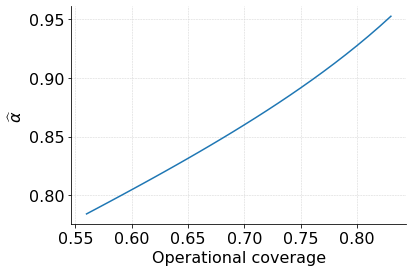

In [6]:
# inverse map ,take yo for example
def logit(p):
    return np.log(p / (1 - p))

def inverse_map(target):
    f=(logit(target)-np.dot(clf.coef_[:,1:],yo_encoder_s[1,1:])-clf.intercept_)/clf.coef_[:,0]
    x_vec=np.zeros(yo_encoder_s.shape[1])
    x_vec[0]=f
    X_vec=scaler.inverse_transform(x_vec)
    nominal=X_vec[0]
    return nominal

# the target nominal level range
ix=np.arange(0.56,0.84,0.01)
# the correct nominal level
iy=[inverse_map(ix[i]) for i in range(len(ix))]

plt.rcParams["figure.figsize"] = (6,4)
# Create a new figure and axis
fig, ax = plt.subplots()

# Plot the data
ax.plot(ix,iy)

ax.set_xlabel("Operational coverage",fontsize=16)
ax.set_ylabel(r'$\widehat{\alpha}$',fontsize=16)
ax.tick_params(axis='both', labelsize=16) 

# Customize the grid
ax.grid(True, linestyle='dashed', linewidth=0.5, color='lightgray')

# Hide the axis lines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


plt.show()

###  Application: output the calibrated credible set

Considering a desired nominal level at 0.8

In [9]:
alpha_new=inverse_map(0.8)
fdot_chain_est=np.load("./fdot_chain_est for test signal.npy")
fdot_chain=np.load("./fdot_chain for test signal.npy")

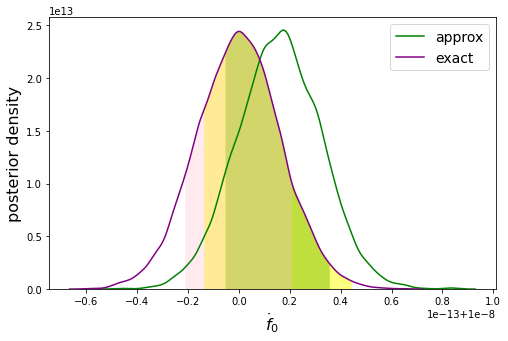

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde

burnin=1000

samples_est = fdot_chain_est[burnin::]
samples = fdot_chain[burnin::]

#----------------------------------------------------------
# get the credible interval for each posterior distribution]

lower_bound_est_new, upper_bound_est_new = np.percentile(samples_est, [(1-alpha_new)*50, (1-(1-alpha_new)/2)*100])
lower_bound_est, upper_bound_est = np.percentile(samples_est, [10, 90])
lower_bound, upper_bound = np.percentile(samples, [10, 90])

x1 =  np.arange(lower_bound, upper_bound, 1e-15)
kde1 = gaussian_kde(samples)
y1 = kde1.evaluate(x1)

x2 =  np.arange(lower_bound_est, upper_bound_est, 1e-15)
kde2 = gaussian_kde(samples_est)
y2 = kde1.evaluate(x2)

x3 =  np.arange(lower_bound_est_new, upper_bound_est_new, 1e-15)
y3 = kde1.evaluate(x3)

#------------------------------------------------------------
# Create a kernel density estimate plot of the data
# hard code to display the calibrated region, the yellow one is the calibrated region
# the calibrated region has the similar area as the original 0.8 credible interval made by MCMC with the exact waveform

plt.rcParams["figure.figsize"] = (8,5)

sns.kdeplot(samples_est,c='green',label="approx")
sns.kdeplot(samples,c='purple',label="exact")
plt.fill_between(x2, y2, alpha=0.5,facecolor="green")
plt.fill_between(x3, y3, alpha=0.5,facecolor="yellow")
plt.fill_between(x1, y1, alpha=0.3,facecolor="pink")


plt.legend(loc='upper right',fontsize=14)
plt.xlabel(r'$\dot{f}_{0}$',fontsize=16)
plt.ylabel("posterior density",fontsize=16)
plt.show()